In [1]:
#importing the important libraries
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision
import torch.nn as nn


import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#what GPUs are available
dp = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dp

device(type='cuda')

In [3]:
#implementing the VAE 
class VariationalAutoEncoder(nn.Module):
    def __init__(self, number_of_samples=1, imagefeaturedimension=32*20*20, Zdim=20):
        super(VariationalAutoEncoder, self).__init__()

        #onvolutional layers with full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(number_of_samples, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(imagefeaturedimension, Zdim)
        self.encFC2 = nn.Linear(imagefeaturedimension, Zdim)

        # fully-connected layer with onvolutional layers for decoder
        self.decFC1 = nn.Linear(Zdim, imagefeaturedimension)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, number_of_samples, 5)

    #encoder method
    def encoder(self, x_val):
        x_val = F.relu(self.encConv1(x_val))
        x_val = F.relu(self.encConv2(x_val))
        x_val = x_val.view(-1, 32*20*20)
        mu = self.encFC1(x_val)
        logVariation = self.encFC2(x_val)
        return mu, logVariation

    #Reparameterization method
    def reparameterize(self, mu, logVariation):
        std = torch.exp(logVariation/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    #decoder method
    def decoder(self, z):
        x_val = F.relu(self.decFC1(z))
        x_val = x_val.view(-1, 32, 20, 20)
        x_val = F.relu(self.decConv1(x_val))
        x_val = torch.sigmoid(self.decConv2(x_val))
        return x_val
    #feed forward method
    def forward(self, x):
        mu, logVariation = self.encoder(x)
        z = self.reparameterize(mu, logVariation)
        out = self.decoder(z)
        return out, mu, logVariation

In [4]:
#training procedure implementation
#defining Hyperparameters
learning_rate = 1e-3
num_epochs = 10  #change the no of epochs to 80 and compare results as well
batch_size = 128


#Creating  dataloaders to feed data to the NN
training_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
testing_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)



#defining the network with the Adam optimizer

net = VariationalAutoEncoder().to(dp)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


#training the network
for epoch in range(num_epochs):
    for idx, data in enumerate(training_loader, 0):
        images, _ = data
        images = images.to(dp)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(images)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, images, size_average=False) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 11148.2880859375
Epoch 1: Loss 10158.416015625
Epoch 2: Loss 10007.6220703125
Epoch 3: Loss 10543.0166015625
Epoch 4: Loss 9802.322265625
Epoch 5: Loss 10318.798828125
Epoch 6: Loss 9935.015625
Epoch 7: Loss 9542.548828125
Epoch 8: Loss 9277.42578125
Epoch 9: Loss 9526.189453125


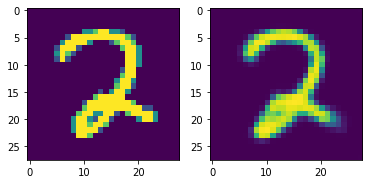

In [5]:
#visualizing the data to make comparisons (ploting both original and new image to monitor the changes)

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(testing_loader), 1):
        images, _ = data
        images = images.to(dp)
        img = np.transpose(images[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVariation = net(images)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

END OF IMPLEMENTATION AND TESTING!!! THANK YOU!!!